In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn import metrics
#%pip install lightgbm
import math

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
bd = pd.read_csv('/content/drive/My Drive/Базы/акции лукойл/18_19.csv', sep=';')
bd

In [ ]:
bd["DATE"] = pd.to_datetime(bd["DATE"])
bd["TIME"] = pd.to_timedelta(bd["TIME"])# ПРЕОБРАЗУЕМ ВРЕМЯ В НУЖНЫЙ ТИП ДАБЫ СКОНКОТЕНИРОВАТЬ БЕЗ ОШИБОК 
#                                          https://translated.turbopages.org/proxy_u/en-ru.ru.b09a760b-63426bac-124238b6-74722d776562/https/stackoverflow.com/questions/17978092/combine-date-and-time-columns-using-pandas
from datetime import datetime
import time
bd['DATA']= pd.to_datetime( bd['DATE'] +  bd['TIME'], format='%d-%m-%Y%H:%M:%S')
bd=bd.drop(['DATE'], axis=1)
bd=bd.drop(['TIME'], axis=1)
bd

In [56]:
def data_prep(df):
    df = df.iloc[:, 0:5]
    df['Price_dol'] = df['CLOSE'] * df['VOLUME']
    a = np.diff(df['CLOSE'])
    a = np.insert(a, 0, 0)
    df['Delta'] = pd.DataFrame(a)
    return df

In [57]:
bd1= data_prep(bd)
bd1

,OPEN,MAX,MIN,CLOSE,VOLUME,Price_dol,Delta
0,3341.0,3356.0,3340.0,3355.0,6088,20425240.0,0.0
1,3355.0,3359.0,3353.0,3353.0,1624,5445272.0,-2.0
2,3351.5,3357.5,3351.5,3357.5,722,2424115.0,4.5
3,3354.5,3360.0,3354.5,3358.0,3034,10188172.0,0.5
4,3358.0,3360.0,3351.5,3360.0,1427,4794720.0,2.0
...,...,...,...,...,...,...,...
217942,5183.5,5183.5,5183.5,5183.5,31523,163399470.5,11.5
217943,5183.5,5183.5,5183.5,5183.5,5090,26384015.0,0.0
217944,5183.5,5183.5,5183.5,5183.5,230,1192205.0,0.0
217945,5183.5,5183.5,5183.5,5183.5,5,25917.5,0.0


In [58]:
def labelling(df):
    b = np.ones(len(df['CLOSE']))
    for i, delta in enumerate(df['Delta']):
        if i > 0:
            if delta == 0:
                b[i] = b[i-1]
            else:
                b[i] = abs(delta) / delta
    df['Label'] = b
    return df

In [ ]:
bd2= labelling(bd1)
bd2

In [ ]:
bd2['DATA'] = bd['DATA'] 
bd2

In [61]:
def bar_gen_run(df, thresh):
    cumm, open, low, high, close, cumm_vol, vol_price, b, s = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
    collector, bar, thresh_buffer = [], [], []

    for i, (label, CLOSE, DATA, VOLUME) in enumerate(zip(df['Label'], df['CLOSE'], df['DATA'], df['VOLUME'])):
        if label == 1:
            b = b + label
        else:
            s = s + label
        theta = max(b, abs(s))

        cumm_vol = cumm_vol + VOLUME
        vol_price = vol_price + (CLOSE * VOLUME)
        collector.append(CLOSE)
        if theta >= thresh:
            open = collector[0]
            high = np.max(collector)
            low = np.min(collector)
            close = collector[-1]
            vwap = vol_price / cumm_vol
            bar.append((DATA, i, open, low, high, close, vwap))
            a = len(collector) * max(((b/len(collector)), (1-(b/len(collector)))))
            thresh_buffer.append(a)
            if i > 500000: thresh = np.average(thresh_buffer)
            theta, open, low, high, close, cumm_vol, vol_price, b, s = 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0
            collector = []
    cols = ['Date', 'Index', 'Open', 'Low', 'High', 'Close', 'Vwap']
    run_bar = pd.DataFrame(bar, columns= cols)
    return run_bar

In [62]:
bd4 = bar_gen_run(bd2, 100)
bd4

,Date,Index,Open,Low,High,Close,Vwap
0,2018-03-01 13:15:00,195,3355.0,3350.0,3414.5,3407.0,3390.785097
1,2018-03-01 16:28:00,388,3406.5,3399.5,3419.0,3414.0,3410.019595
2,2018-04-01 10:54:00,575,3414.5,3396.0,3441.5,3423.0,3417.648521
3,2018-04-01 13:55:00,756,3423.0,3402.5,3457.5,3455.0,3428.219125
4,2018-04-01 17:01:00,942,3456.0,3448.5,3479.0,3471.5,3464.137441
...,...,...,...,...,...,...,...
1162,2019-08-22 11:58:00,217015,5283.5,5242.5,5302.0,5249.5,5276.204529
1163,2019-08-22 15:11:00,217208,5251.5,5237.5,5279.5,5271.5,5256.290778
1164,2019-08-22 18:26:00,217403,5272.0,5242.0,5287.5,5278.5,5266.005553
1165,2019-08-23 12:58:00,217600,5278.5,5200.0,5286.5,5225.5,5235.506761


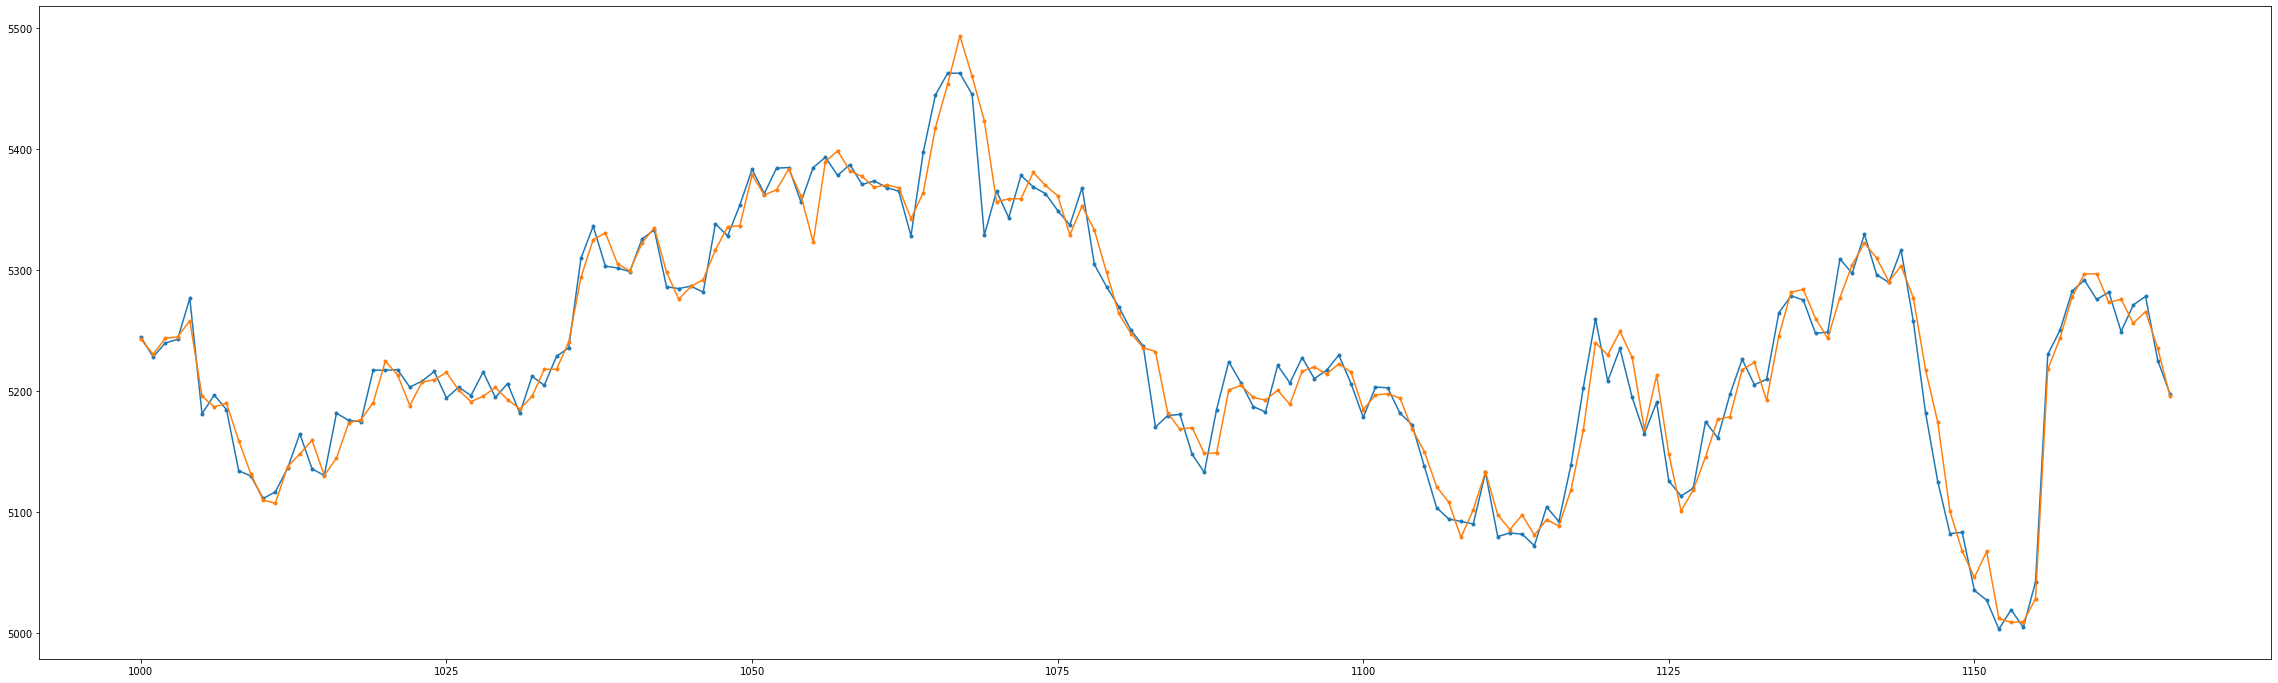

In [63]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,12))
#plt.plot(cycle, marker='.')
plt.plot(bd4.Close[1000:], marker='.')
plt.plot(bd4.Vwap[1000:], marker='.')
plt.show()

 **КОНЕЦ ЧИСТОЙ ВЕРСИИ**

In [31]:
def initial_conditions(df):
    prob = pd.DataFrame(pd.pivot_table(df, index='Label', values='CLOSE', aggfunc='count'))
    prob = np.array(prob)
    p_b = prob[1]/(prob[0]+prob[1])
    p_s = prob[0]/(prob[0]+prob[1])
    return p_b, p_s

ДОЛЛАР БАР  1 ВЕРСИЯ НАЧАЛО

In [ ]:
bd['Dollar'] = bd['CLOSE'] * bd['VOLUME']
print(bd.columns)

In [20]:
# Generate thresholds
d = pd.DataFrame(pd.pivot_table(bd, values='Dollar', aggfunc='sum', index='DATA'))
DOLLAR_THRESHOLD = (1 / 50) * np.average(d['Dollar'])

In [22]:
DOLLAR_THRESHOLD

141472.2627706277

In [37]:
def bar_gen(bd, DOLLAR_THRESHOLD):
    collector, dollarbar_tmp = [], []
    dollar_cusum = 0
    for i, (CLOSE, dollar) in enumerate(zip(bd['CLOSE'], bd['Dollar'])):
        collector.append(CLOSE)
        dollar_cusum = dollar_cusum + dollar
        if dollar_cusum >= DOLLAR_THRESHOLD:
            o, h, l, c = collector[0], np.max(collector), np.min(collector), collector[-1]
            dollarbar_tmp.append((i, o, h, l, c))
            o, h, l, c, dollar_cusum = 0, 0, 0, 0, 0
            collector = []
    cols = ['Index', 'Open', 'High', 'Low', 'Close',]
    dollarbar = pd.DataFrame(dollarbar_tmp, columns=cols)
    return dollarbar

In [38]:
dollarba = bar_gen(bd, DOLLAR_THRESHOLD)
dollarba

,Index,Open,High,Low,Close
0,0,3355.0,3355.0,3355.0,3355.0
1,1,3353.0,3353.0,3353.0,3353.0
2,2,3357.5,3357.5,3357.5,3357.5
3,3,3358.0,3358.0,3358.0,3358.0
4,4,3360.0,3360.0,3360.0,3360.0
...,...,...,...,...,...
201172,217941,5172.0,5172.0,5172.0,5172.0
201173,217942,5183.5,5183.5,5183.5,5183.5
201174,217943,5183.5,5183.5,5183.5,5183.5
201175,217944,5183.5,5183.5,5183.5,5183.5


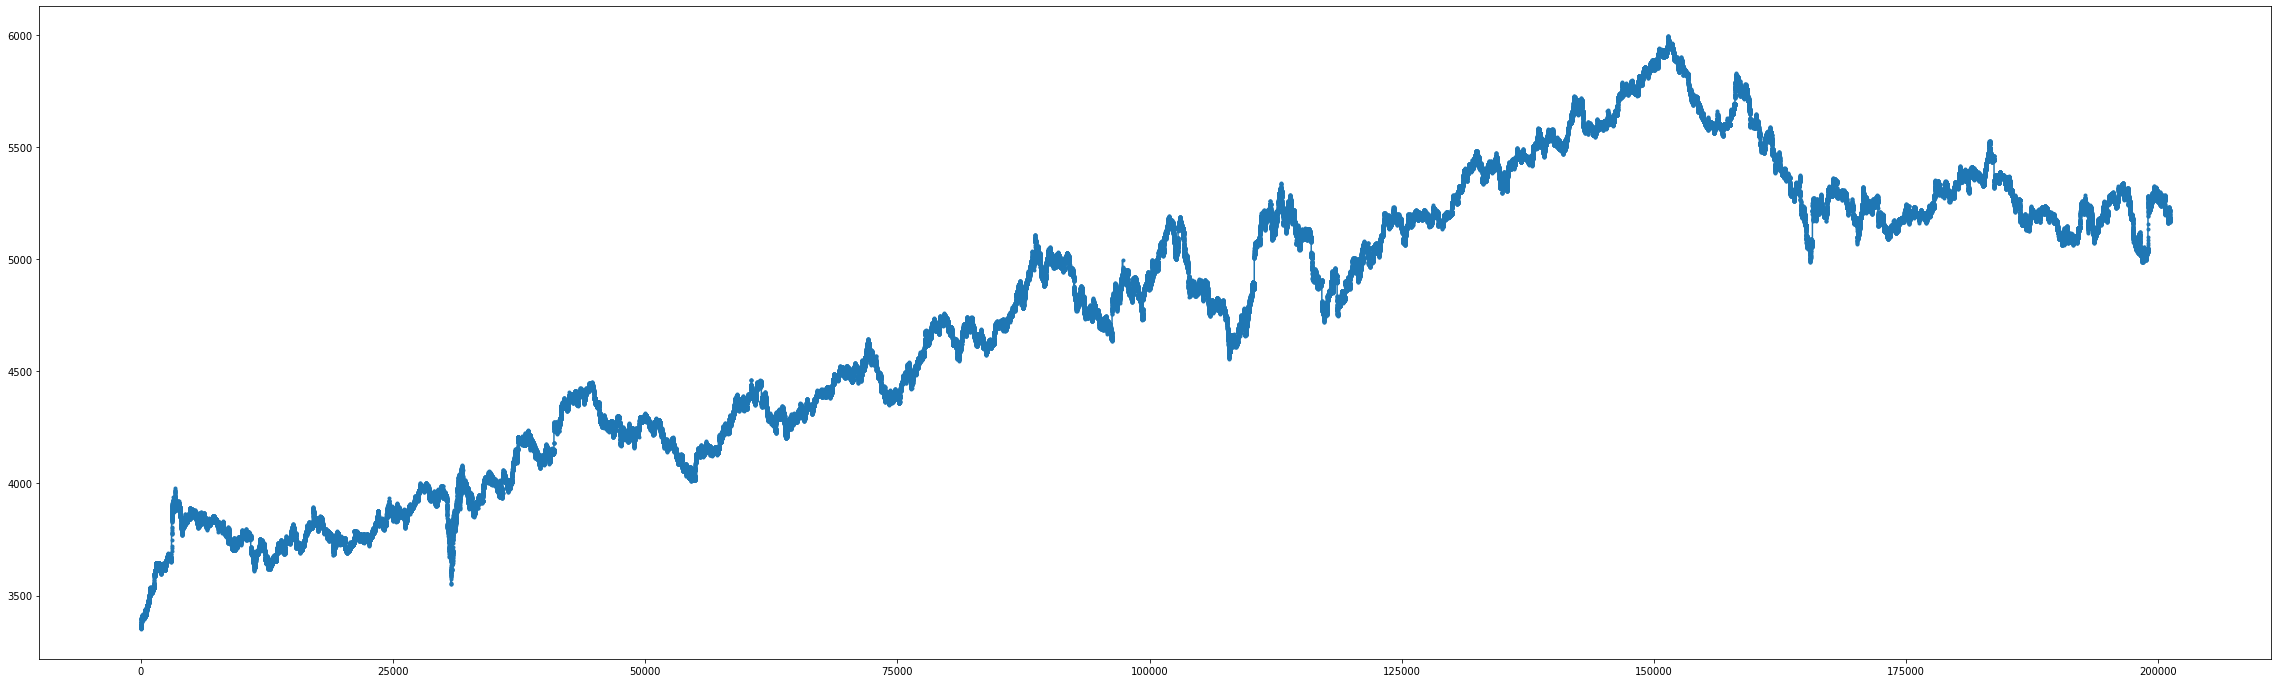

In [39]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,12))
#plt.plot(cycle, marker='.')
plt.plot(dollarba.Close, marker='.')
plt.show()

ДОЛЛАР БАР 1 ВЕРСИЯ КОНЕЦ

In [13]:
gg = bd.iloc[:, 0:6]
gg

,OPEN,MAX,MIN,CLOSE,VOLUME,DATA
0,3341.0,3356.0,3340.0,3355.0,6088,2018-03-01 10:00:00
1,3355.0,3359.0,3353.0,3353.0,1624,2018-03-01 10:01:00
2,3351.5,3357.5,3351.5,3357.5,722,2018-03-01 10:02:00
3,3354.5,3360.0,3354.5,3358.0,3034,2018-03-01 10:03:00
4,3358.0,3360.0,3351.5,3360.0,1427,2018-03-01 10:04:00
...,...,...,...,...,...,...
217942,5183.5,5183.5,5183.5,5183.5,31523,2019-08-23 18:45:00
217943,5183.5,5183.5,5183.5,5183.5,5090,2019-08-23 18:46:00
217944,5183.5,5183.5,5183.5,5183.5,230,2019-08-23 18:47:00
217945,5183.5,5183.5,5183.5,5183.5,5,2019-08-23 18:48:00


In [11]:
bd

,OPEN,MAX,MIN,CLOSE,VOLUME,DATA
0,3341.0,3356.0,3340.0,3355.0,6088,2018-03-01 10:00:00
1,3355.0,3359.0,3353.0,3353.0,1624,2018-03-01 10:01:00
2,3351.5,3357.5,3351.5,3357.5,722,2018-03-01 10:02:00
3,3354.5,3360.0,3354.5,3358.0,3034,2018-03-01 10:03:00
4,3358.0,3360.0,3351.5,3360.0,1427,2018-03-01 10:04:00
...,...,...,...,...,...,...
217942,5183.5,5183.5,5183.5,5183.5,31523,2019-08-23 18:45:00
217943,5183.5,5183.5,5183.5,5183.5,5090,2019-08-23 18:46:00
217944,5183.5,5183.5,5183.5,5183.5,230,2019-08-23 18:47:00
217945,5183.5,5183.5,5183.5,5183.5,5,2019-08-23 18:48:00


In [ ]:
def generate_tickbars(ticks, frequency=1000):
    times = ticks[:,0]
    prices = ticks[:,1]
    volumes = ticks[:,2]
    res = np.zeros(shape=(len(range(frequency, len(prices), frequency)), 6))
    it = 0
    for i in range(frequency, len(prices), frequency):
        res[it][0] = times[i-1]                        # time
        res[it][1] = prices[i-frequency]               # open
        res[it][2] = np.max(prices[i-frequency:i])     # high
        res[it][3] = np.min(prices[i-frequency:i])     # low
        res[it][4] = prices[i-1]                       # close
        res[it][5] = np.sum(volumes[i-frequency:i])    # volume
        it += 1
    return res

In [ ]:
bd

In [ ]:
fast_ma=100
slow_ma=200
bd['Log_Price'] = np.log(bd['CLOSE'])
bd['LOG_sred_fast']=bd['Log_Price'].rolling(window=fast_ma).mean()          #Средние колво заказов за 7 дней
bd['LOG_sred_slow']=bd['Log_Price'].rolling(window=slow_ma).mean()         #Средние колво заказов за 14 дней 
#bd['sred_fast']=bd['CLOSE'].rolling(window=fast_ma).mean()          #Средние колво заказов за 7 дней
#bd['sred_slow']=bd['CLOSE'].rolling(window=slow_ma).mean()         #Средние колво заказов за 14 дней 
bd=bd[200:]                                                              #убрал полученные нан значения от расчетов
bd

СОЗДАЕМ VWAP


In [ ]:
Typical Price [(H + L + C) / 3]
VWAP = ∑ (Типичная цена * Объем) / ∑ Объем
def calculate_vwap(df): 
    q = df['VOLUME'] 
    p = df['price'] 
    vwap = np.sum(p * q) / np.sum(q) 
    df['vwap'] = vwap 
    return df
    def calculate_vwap(df): 
    q = df['foreignNotional'] 
    p = df['price'] 
    vwap = np.sum(p * q) / np.sum(q) 
    df['vwap'] = vwap 
    return df
data_timeidx = data.set_index('timestamp') 
data_time_grp = data_timeidx.groupby(pd.Grouper(freq='15Min')) 
num_time_bars = len(data_time_grp) # пригодится позже 
data_time_vwap = data_time_grp.apply(compute_vwap)

In [204]:
bd

,OPEN,MAX,MIN,CLOSE,VOLUME,DATA
0,3341.0,3356.0,3340.0,3355.0,6088,2018-03-01 10:00:00
1,3355.0,3359.0,3353.0,3353.0,1624,2018-03-01 10:01:00
2,3351.5,3357.5,3351.5,3357.5,722,2018-03-01 10:02:00
3,3354.5,3360.0,3354.5,3358.0,3034,2018-03-01 10:03:00
4,3358.0,3360.0,3351.5,3360.0,1427,2018-03-01 10:04:00
...,...,...,...,...,...,...
217942,5183.5,5183.5,5183.5,5183.5,31523,2019-08-23 18:45:00
217943,5183.5,5183.5,5183.5,5183.5,5090,2019-08-23 18:46:00
217944,5183.5,5183.5,5183.5,5183.5,230,2019-08-23 18:47:00
217945,5183.5,5183.5,5183.5,5183.5,5,2019-08-23 18:48:00


In [205]:
bd['HLC'] = (bd['MAX']+bd['MIN']+bd['CLOSE'])/3


In [227]:
pd.isnull(ff).sum()

52747

In [206]:
def vwap(data):
    return (data.HLC * data.VOLUME).sum() / data.VOLUME.sum()

In [211]:
cc = bd.set_index('DATA') 

In [212]:
ff=cc.groupby(pd.Grouper(freq="15min")).apply(vwap)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


In [ ]:
ff[70:120]


In [ ]:
aa=pd.DataFrame(ff)
aa

In [ ]:
aa.columns= ['PRICE']
aa

In [ ]:
aa.dropna()

In [ ]:
bd


In [ ]:
bd['DATA'] = pd.to_datetime(bd['DATA'])
bd = bd.set_index('DATA') 
bd

In [248]:
bd.resample("15T").apply(vwap)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in double_scalars
  


DATA
2018-01-02 10:00:00    3733.746249
2018-01-02 10:15:00    3738.072596
2018-01-02 10:30:00    3740.240408
2018-01-02 10:45:00    3746.576429
2018-01-02 11:00:00    3734.538256
                          ...     
2019-12-08 17:45:00    5331.369976
2019-12-08 18:00:00    5336.232412
2019-12-08 18:15:00    5329.054478
2019-12-08 18:30:00    5319.894920
2019-12-08 18:45:00    5320.000000
Freq: 15T, Length: 67716, dtype: float64

In [236]:
pd.isnull(aa).sum()

PRICE    52747
dtype: int64

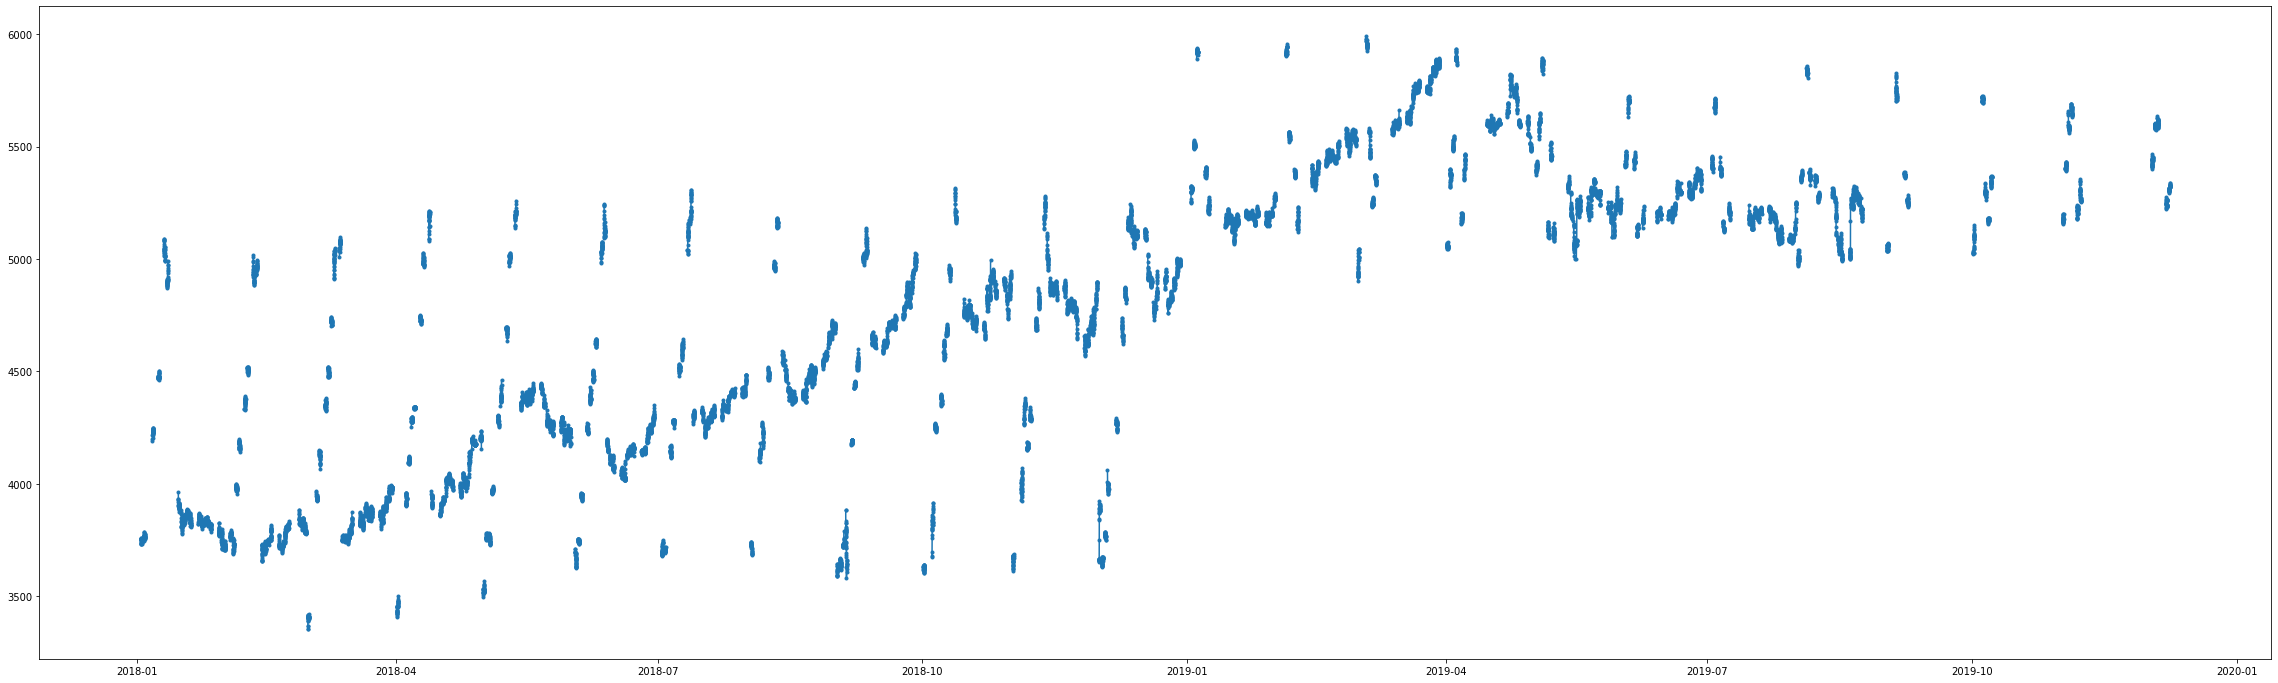

In [237]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,12))
#plt.plot(cycle, marker='.')
plt.plot(aa, marker='.')
plt.show()

In [240]:
ff.resample("15min").apply(vwap)
ff

AttributeError: ignored

In [193]:
data_timeidx.index = pd.to_datetime(data_timeidx.index)
data_timeidx.index.name = 'DATA'

In [ ]:
data_timeidx

In [198]:
data_time_grp = bd.groupby(pd.Grouper(key='DATA',freq='15T'))

In [ ]:
data_time_grp

In [ ]:
df.set_index(['Date'], inplace=True)
df.index = pd.to_datetime(df.index)
df.index.name = 'Date'

In [112]:
num_time_bars = len(data_time_grp)

In [201]:
def calculate_vwap(df): 
    q = bd['VOLUME'] 
    p = bd['CLOSE'] 
    vwap = np.sum(p * q) / np.sum(q) 
    df['VWAP'] = vwap 
    return df

In [202]:
data_time_vwap = data_time_grp.apply(calculate_vwap)

In [203]:
data_time_vwap

,OPEN,MAX,MIN,CLOSE,VOLUME,DATA,VWAP
10474,3728.0,3730.0,3722.5,3723.5,512,2018-01-02 10:00:00,4749.125509
10475,3724.5,3731.0,3723.0,3729.0,4331,2018-01-02 10:01:00,4749.125509
10476,3730.0,3730.0,3724.5,3729.0,2728,2018-01-02 10:02:00,4749.125509
10477,3730.0,3731.5,3726.5,3728.0,868,2018-01-02 10:03:00,4749.125509
10478,3728.5,3733.0,3727.0,3731.5,1042,2018-01-02 10:04:00,4749.125509
...,...,...,...,...,...,...,...
213222,5320.0,5320.0,5320.0,5320.0,15332,2019-12-08 18:45:00,4749.125509
213223,5320.0,5320.0,5320.0,5320.0,800,2019-12-08 18:46:00,4749.125509
213224,5320.0,5320.0,5320.0,5320.0,101,2019-12-08 18:47:00,4749.125509
213225,5320.0,5320.0,5320.0,5320.0,148,2019-12-08 18:48:00,4749.125509


In [129]:
def vwap(df):
    q = df.quantity.values
    p = df.price.values
    return df.assign(vwap=(p * q).cumsum() / q.cumsum())



In [133]:
bd

,OPEN,MAX,MIN,CLOSE,VOLUME,DATA,Log_Price,LOG_sred_fast,LOG_sred_slow
200,3407.5,3408.0,3407.0,3408.0,1059,2018-03-01 13:20:00,8.133881,8.133035,8.128437
201,3408.0,3409.0,3408.0,3409.0,427,2018-03-01 13:21:00,8.134174,8.133082,8.128520
202,3408.0,3409.0,3407.5,3409.0,234,2018-03-01 13:22:00,8.134174,8.133126,8.128596
203,3408.5,3408.5,3408.0,3408.0,37,2018-03-01 13:23:00,8.133881,8.133167,8.128670
204,3408.5,3410.0,3408.5,3408.5,495,2018-03-01 13:24:00,8.134028,8.133218,8.128741
...,...,...,...,...,...,...,...,...,...
217942,5183.5,5183.5,5183.5,5183.5,31523,2019-08-23 18:45:00,8.553236,8.557126,8.555799
217943,5183.5,5183.5,5183.5,5183.5,5090,2019-08-23 18:46:00,8.553236,8.557082,8.555806
217944,5183.5,5183.5,5183.5,5183.5,230,2019-08-23 18:47:00,8.553236,8.557038,8.555814
217945,5183.5,5183.5,5183.5,5183.5,5,2019-08-23 18:48:00,8.553236,8.556991,8.555821


In [134]:
fc = bd.set_index('DATA') 

In [137]:
fc

,OPEN,MAX,MIN,CLOSE,VOLUME,Log_Price,LOG_sred_fast,LOG_sred_slow
DATA,,,,,,,,
2018-03-01 13:20:00,3407.5,3408.0,3407.0,3408.0,1059,8.133881,8.133035,8.128437
2018-03-01 13:21:00,3408.0,3409.0,3408.0,3409.0,427,8.134174,8.133082,8.128520
2018-03-01 13:22:00,3408.0,3409.0,3407.5,3409.0,234,8.134174,8.133126,8.128596
2018-03-01 13:23:00,3408.5,3408.5,3408.0,3408.0,37,8.133881,8.133167,8.128670
2018-03-01 13:24:00,3408.5,3410.0,3408.5,3408.5,495,8.134028,8.133218,8.128741
...,...,...,...,...,...,...,...,...
2019-08-23 18:45:00,5183.5,5183.5,5183.5,5183.5,31523,8.553236,8.557126,8.555799
2019-08-23 18:46:00,5183.5,5183.5,5183.5,5183.5,5090,8.553236,8.557082,8.555806
2019-08-23 18:47:00,5183.5,5183.5,5183.5,5183.5,230,8.553236,8.557038,8.555814


In [136]:
df = fc.groupby(fc.index.DATA, group_keys=False).apply(vwap)


AttributeError: ignored

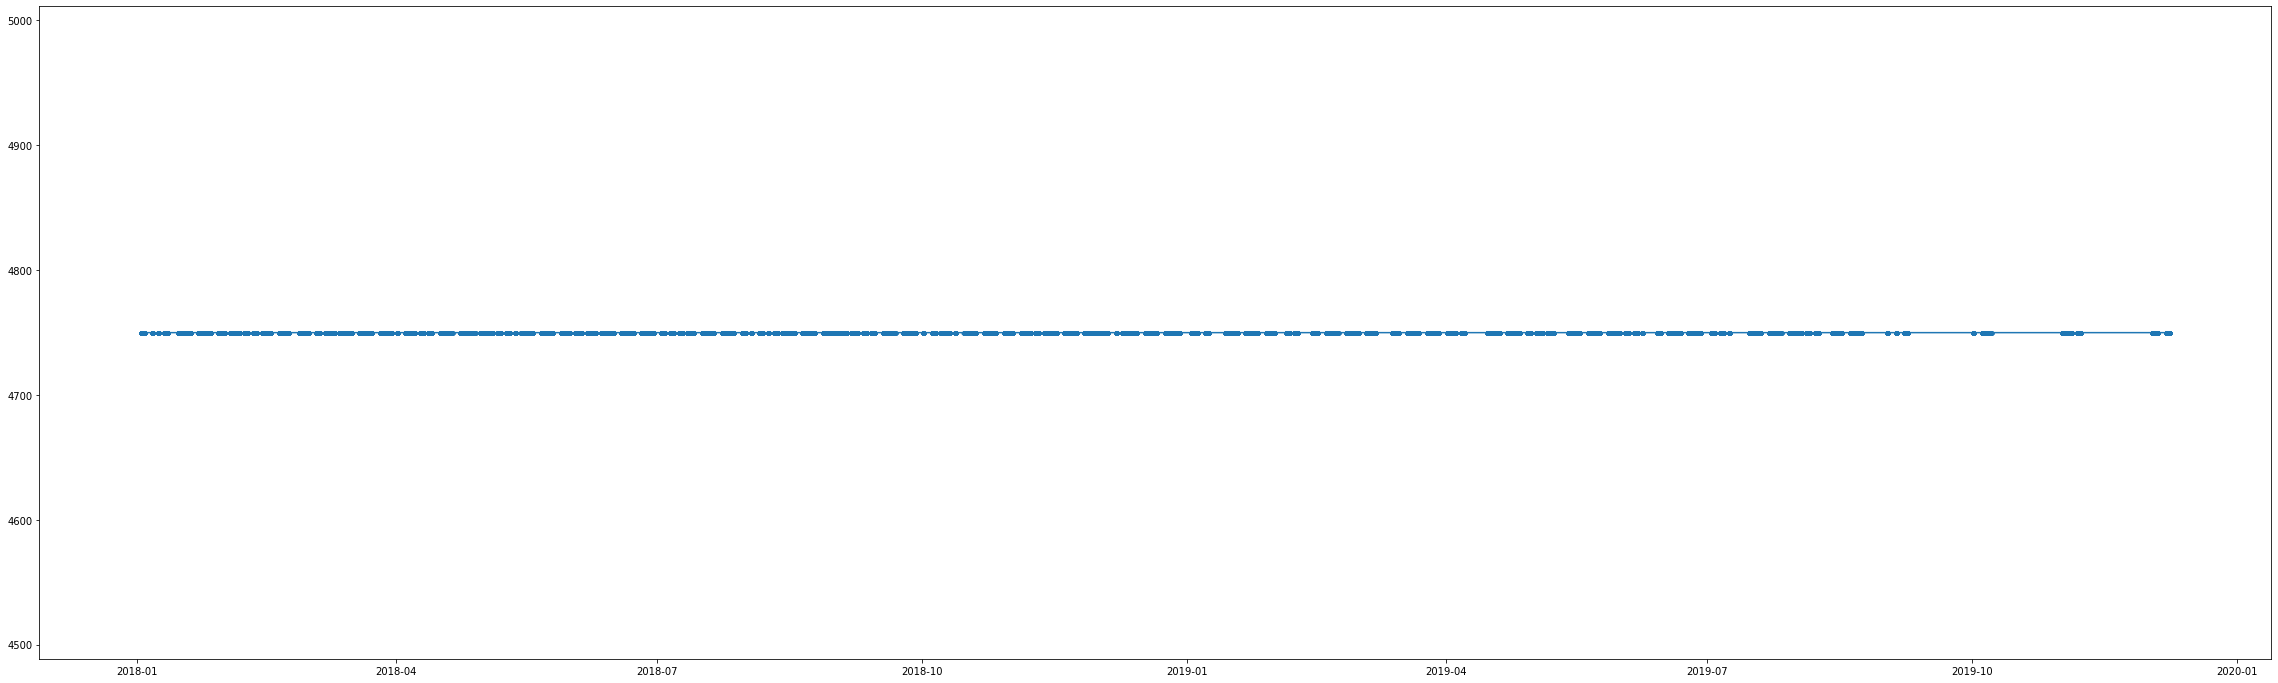

In [96]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,12))
#plt.plot(cycle, marker='.')
plt.plot(data_time_vwap.VWAP, marker='.')
plt.show()

In [ ]:
bd['HLC'] = (bd['MAX']+bd['MIN']+bd['CLOSE'])/3


In [ ]:
bd['VWAP']= bd['HLS']*bd

In [38]:
bd1 = bd.set_index(pd.DatetimeIndex(bd['DATA']))# преобразую даты в индексы

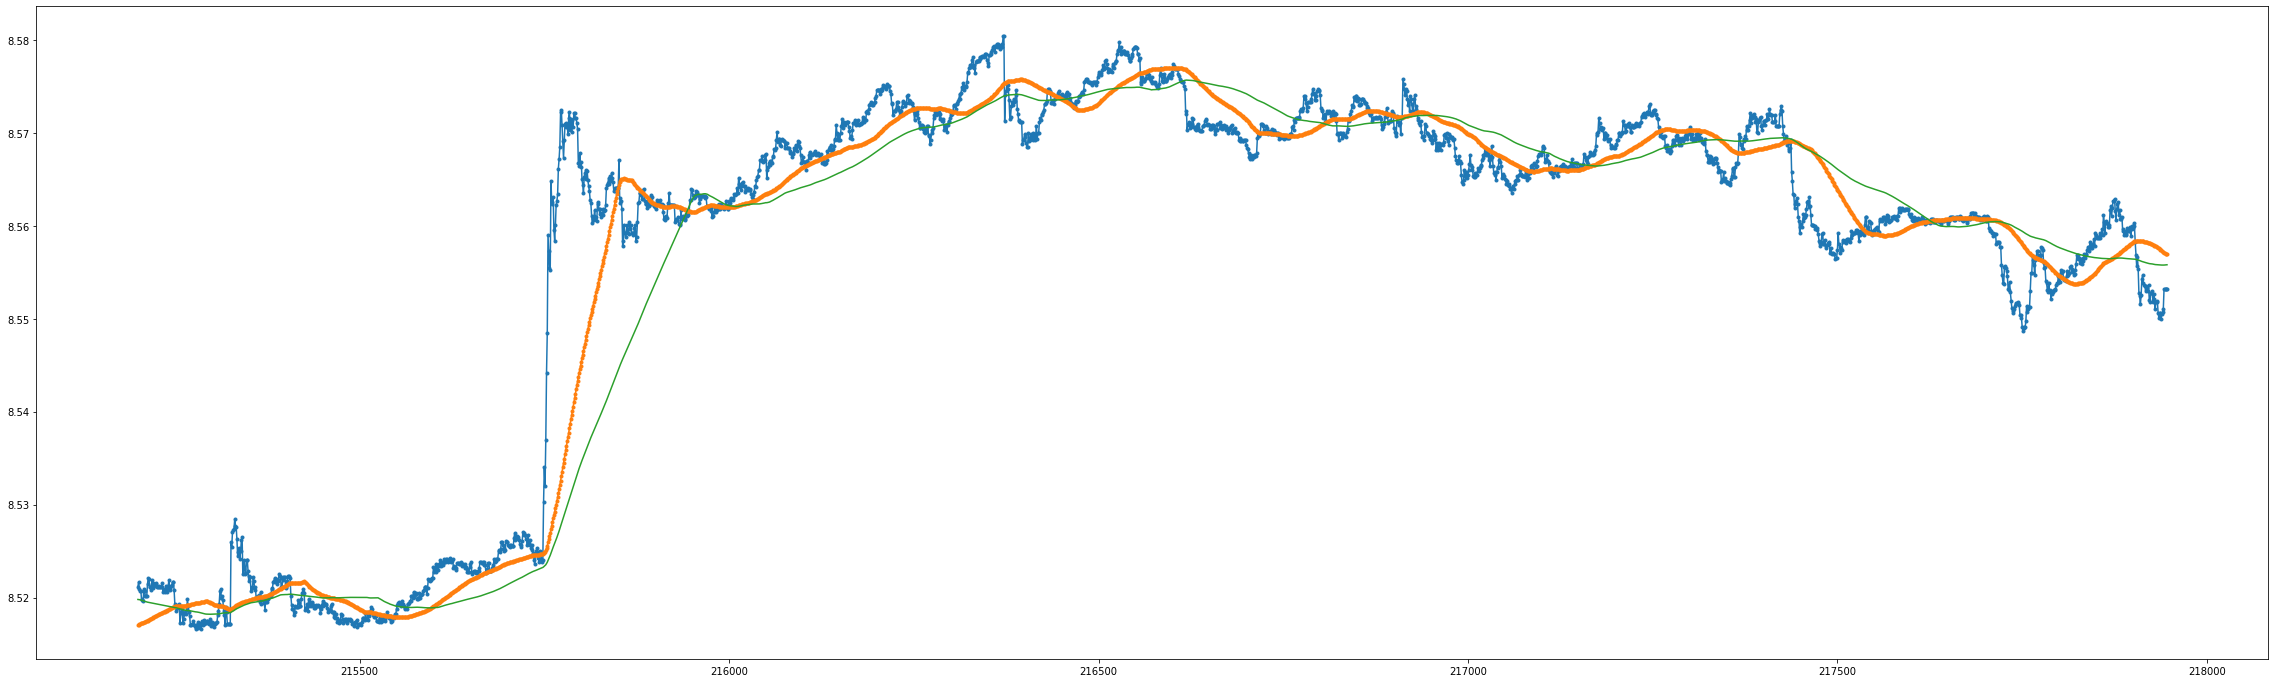

In [56]:
import matplotlib.pyplot as plt
plt.figure(figsize=(40,12))
#plt.plot(cycle, marker='.')
plt.plot(bd.Log_Price[215000:], marker='.')
#plt.plot(open_trend[6050:])
plt.plot(bd.LOG_sred_za_7d[215000:], marker='.')
plt.plot(bd.LOG_sred_za_14d[215000:])
plt.show()

In [74]:
bd['prof']=bd['CLOSE'][1:].reset_index(drop=True)/bd['CLOSE'][:-1].reset_index(drop=True)-1
bd

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,OPEN,MAX,MIN,CLOSE,VOLUME,DATA,Log_Price,LOG_sred_za_7d,LOG_sred_za_14d,sred_za_7d,sred_za_14d,prof
200,3407.5,3408.0,3407.0,3408.0,1059,2018-03-01 13:20:00,8.133881,8.133035,8.128437,3405.120,3389.5525,0.000000
201,3408.0,3409.0,3408.0,3409.0,427,2018-03-01 13:21:00,8.134174,8.133082,8.128520,3405.280,3389.8325,-0.000586
202,3408.0,3409.0,3407.5,3409.0,234,2018-03-01 13:22:00,8.134174,8.133126,8.128596,3405.430,3390.0900,0.000587
203,3408.5,3408.5,3408.0,3408.0,37,2018-03-01 13:23:00,8.133881,8.133167,8.128670,3405.570,3390.3400,-0.000293
204,3408.5,3410.0,3408.5,3408.5,495,2018-03-01 13:24:00,8.134028,8.133218,8.128741,3405.745,3390.5825,-0.000440
...,...,...,...,...,...,...,...,...,...,...,...,...
217942,5183.5,5183.5,5183.5,5183.5,31523,2019-08-23 18:45:00,8.553236,8.557126,8.555799,5203.745,5196.8325,NaN
217943,5183.5,5183.5,5183.5,5183.5,5090,2019-08-23 18:46:00,8.553236,8.557082,8.555806,5203.515,5196.8725,NaN
217944,5183.5,5183.5,5183.5,5183.5,230,2019-08-23 18:47:00,8.553236,8.557038,8.555814,5203.285,5196.9100,NaN
217945,5183.5,5183.5,5183.5,5183.5,5,2019-08-23 18:48:00,8.553236,8.556991,8.555821,5203.040,5196.9500,NaN


In [61]:
pd.isnull(bd.prof).sum()

201

In [ ]:
pr = bd[:-201:]
pr

In [ ]:
#ДОБАВЛЯЮ СТОЛБЦЫ В  ТАБЛ где даты  индекс
fast_ma=5
slow_ma=20
bd1['Log_Price'] = np.log(bd1['CLOSE'])
bd1['LOG_sred_za_7d']=bd1['Log_Price'].rolling(window=fast_ma).mean()          #Средние колво заказов за 7 дней
bd1['LOG_sred_za_14d']=bd1['Log_Price'].rolling(window=slow_ma).mean()         #Средние колво заказов за 14 дней 
bd1['sred_za_7d']=bd1['CLOSE'].rolling(window=fast_ma).mean()          #Средние колво заказов за 7 дней
bd1['sred_za_14d']=bd1['CLOSE'].rolling(window=slow_ma).mean()         #Средние колво заказов за 14 дней 
bd1=bd1[20:]                                                              #убрал полученные нан значения от расчетов
bd1

In [77]:
pd.isnull(pr.prof).sum()

0

In [ ]:
bd 

In [ ]:
pr['STRATEGY'] = pr['prof']*(pr['LOG_sred_za_7d']>pr['LOG_sred_za_14d']) - pr['prof']*(['LOG_sred_za_7d']<pr['LOG_sred_za_14d'])

<function matplotlib.pyplot.legend(*args, **kwargs)>

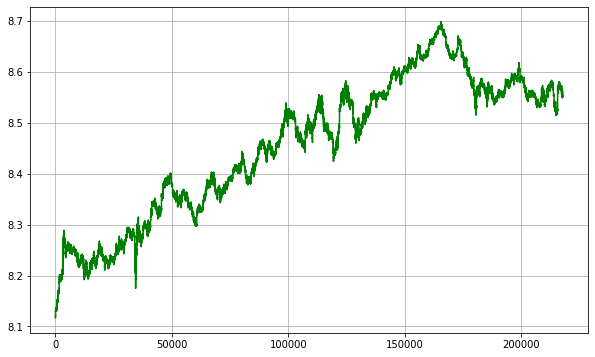

In [32]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(bd['Log_Price'], 'green', label = 'LOG_PRICE')
#plt.plot(bd['CLOSE'], 'red', label = 'PRICE')
plt.legend

In [ ]:
fig, (ax1,ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(bd['Log_Price'], label= 'LOG')
ax2.plot(bd['CLOSE'], label = 'PRICE')
ax1.legend()
ax2.legend()
plt.show()

In [ ]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(bd['Log_Price'], 'green', label = 'LOG_PRICE')
ax2.plot(bd['CLOSE'], 'red', label = 'PRICE')
ax1.set_ylabel('x(t)')
ax2.set_ylabel('y(t)', color='darkred')
plt.show()

In [ ]:
model_predictions = []

n = len(test_data)

In [39]:
bd1=bd1.drop(['DATA'], axis=1)
bd1

,OPEN,MAX,MIN,CLOSE,VOLUME
DATA,,,,,
2018-03-01 10:00:00,3341.0,3356.0,3340.0,3355.0,6088
2018-03-01 10:01:00,3355.0,3359.0,3353.0,3353.0,1624
2018-03-01 10:02:00,3351.5,3357.5,3351.5,3357.5,722
2018-03-01 10:03:00,3354.5,3360.0,3354.5,3358.0,3034
2018-03-01 10:04:00,3358.0,3360.0,3351.5,3360.0,1427
...,...,...,...,...,...
2019-08-23 18:45:00,5183.5,5183.5,5183.5,5183.5,31523
2019-08-23 18:46:00,5183.5,5183.5,5183.5,5183.5,5090
2019-08-23 18:47:00,5183.5,5183.5,5183.5,5183.5,230


In [ ]:
from statsmodels.tsa.arima_model import  ARIMA

In [ ]:
import statsmodels.api as sm

In [ ]:
for i in range(n):
  model = sm.tsa.arima.ARIMA(bd[0:colvo_row]['CLOSE'], order = (5,1,0))
  model_fit = model.fit()
  exit = model_fit.forecast()
  #print(exit)
  #break
  yhad=list(exit)[0]
  #yhad = exit[0]
  model_predictions.append(yhad)
  actual_test_val = test_data[i]
  train_data.append(actual_test_val)

In [ ]:
model = sm.tsa.arima.ARIMA(bd[0:colvo_row]['CLOSE'], order = (5,1,0))
model_fit = model.fit()
exit = model_fit.forecast()

In [ ]:
exit

174361    5679.665041
dtype: float64

In [ ]:
list(exit)[0]

5679.66504058812

In [ ]:
arima_model1 = sm.tsa.arima.ARIMA(train_data, order = (5,1,0))
model1 = arima_model1.fit()

In [ ]:
for i in range(n):
  model = ARIMA(train_data, order = (5,1,0))
  model_fit = model.fit()
  exit = model_fit.forecast()
  yhad= list(exit[0])[0]
  model_predictions.append(yhad)
  actual_test_val = test_data[i]
  train_data.append(actual_test_val)


In [ ]:
print(model_fit.summary())

In [ ]:
plt.figure(figsize=(10,6))
plt.grid(True)
date_range = bd['colvo_row:'].index
plt.plot(date_range, model_predictions[:-1], color= 'blue', marker = 'o', linestyle ='dashed', label= 'predicted_price')
plt.plot(date_range, test_data, color= 'red',  label= 'price')